In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"
links_file = movielens_dir / "links.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)
links = pd.read_csv(links_file)

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
links.loc[(links['movieId']==1)]

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [5]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


In [8]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [9]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [10]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=100,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/100
1418/1418 [==============================] - 12s 7ms/step - loss: 0.6581 - val_loss: 0.6212
Epoch 2/100
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6153 - val_loss: 0.6176
Epoch 3/100
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6100 - val_loss: 0.6142
Epoch 4/100
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6081 - val_loss: 0.6132
Epoch 5/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6084 - val_loss: 0.6118
Epoch 6/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6074 - val_loss: 0.6134
Epoch 7/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6054 - val_loss: 0.6116
Epoch 8/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6071 - val_loss: 0.6127
Epoch 9/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6047 - val_loss: 0.6132
Epoch 10/100
1418/1418 [==============================] - 10s 7ms/s

1418/1418 [==============================] - 9s 6ms/step - loss: 0.6086 - val_loss: 0.6212
Epoch 80/100
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6060 - val_loss: 0.6211
Epoch 81/100
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6117 - val_loss: 0.6198
Epoch 82/100
1418/1418 [==============================] - 13s 10ms/step - loss: 0.6081 - val_loss: 0.6202
Epoch 83/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6106 - val_loss: 0.6251
Epoch 84/100
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6081 - val_loss: 0.6215
Epoch 85/100
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6085 - val_loss: 0.6245
Epoch 86/100
1418/1418 [==============================] - 12s 9ms/step - loss: 0.6105 - val_loss: 0.6207
Epoch 87/100
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6115 - val_loss: 0.6241
Epoch 88/100
1418/1418 [==============================] - 10s 7ms/ste

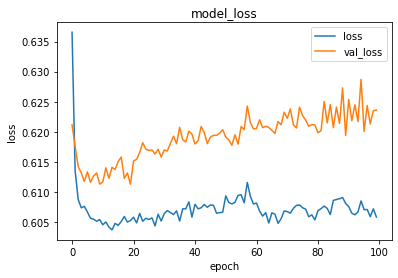

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [66]:
movie_df = pd.read_csv(movielens_dir / 'movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
np. set_printoptions(threshold=np. inf)
print(len(user_movie_array))
print(user_movie_array)
ratings = model.predict(user_movie_array).flatten()
print("This is return array")
print(len(ratings))
print(ratings)
top_ratings_indices = ratings.argsort()[-200:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

9124
[[ 476 5804]
 [ 476  482]
 [ 476  483]
 [ 476    2]
 [ 476  484]
 [ 476  485]
 [ 476 5017]
 [ 476  486]
 [ 476  487]
 [ 476 1399]
 [ 476  488]
 [ 476 3678]
 [ 476  489]
 [ 476  490]
 [ 476  491]
 [ 476 2657]
 [ 476 3604]
 [ 476  291]
 [ 476  493]
 [ 476 2163]
 [ 476  495]
 [ 476  496]
 [ 476  497]
 [ 476 2430]
 [ 476 2068]
 [ 476 6914]
 [ 476  259]
 [ 476 8955]
 [ 476 3938]
 [ 476 3939]
 [ 476  461]
 [ 476 1859]
 [ 476  462]
 [ 476 6704]
 [ 476  498]
 [ 476 5992]
 [ 476  499]
 [ 476  971]
 [ 476  293]
 [ 476  500]
 [ 476 4192]
 [ 476 1400]
 [ 476 5596]
 [ 476    4]
 [ 476 4529]
 [ 476  294]
 [ 476 3711]
 [ 476  501]
 [ 476 3679]
 [ 476 3811]
 [ 476 2651]
 [ 476  295]
 [ 476 3635]
 [ 476  502]
 [ 476  503]
 [ 476  504]
 [ 476 5832]
 [ 476 1401]
 [ 476  505]
 [ 476 1290]
 [ 476 6684]
 [ 476 4035]
 [ 476 2663]
 [ 476    5]
 [ 476 4663]
 [ 476 5550]
 [ 476 4698]
 [ 476 2420]
 [ 476 5018]
 [ 476 9348]
 [ 476 2421]
 [ 476  508]
 [ 476 6915]
 [ 476 4036]
 [ 476 2503]
 [ 476 5687]
 [ 476 

This is return array
9124
[0.7099448  0.5912436  0.60491943 0.7622117  0.61945367 0.6295125
 0.6257037  0.68839383 0.7091588  0.5844338  0.65027046 0.7198866
 0.6269186  0.76538396 0.7320954  0.7045578  0.5824779  0.696526
 0.65069664 0.63566744 0.6921813  0.68611026 0.65062714 0.72415763
 0.7630012  0.6647991  0.6401442  0.6804869  0.6913342  0.69466907
 0.7167132  0.61697286 0.54582405 0.59156835 0.61753184 0.5334508
 0.5432707  0.43578434 0.53960705 0.49463823 0.5368854  0.510306
 0.5487041  0.7516252  0.57299924 0.5709606  0.5895722  0.53423375
 0.5910035  0.5242564  0.5226687  0.6534022  0.5595937  0.55346805
 0.5968873  0.6208085  0.5178844  0.49069604 0.4524237  0.5803255
 0.53393686 0.55014676 0.63858247 0.5778494  0.54001564 0.6333602
 0.64176726 0.6758808  0.58250093 0.6738203  0.6092372  0.5545628
 0.6602047  0.59707016 0.6835107  0.6346641  0.6364527  0.69372326
 0.5784408  0.5989649  0.6252355  0.62333417 0.56606704 0.58792895
 0.6986684  0.5536751  0.6498843  0.695822   0

In [67]:



print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.movieId, ":", row.genres)

Showing recommendations for user: 477
Movies with high ratings from user
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Caddyshack (1980) : Comedy
Battlestar Galactica (2003) : Drama|Sci-Fi|War
WALL·E (2008) : Adventure|Animation|Children|Romance|Sci-Fi
Dr. Horrible's Sing-Along Blog (2008) : Comedy|Drama|Musical|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
6 : Action|Crime|Thriller
11 : Comedy|Drama|Romance
14 : Drama
16 : Crime|Drama
17 : Drama|Romance
28 : Drama|Romance
29 : Adventure|Drama|Fantasy|Mystery|Sci-Fi
36 : Crime|Drama
50 : Crime|Mystery|Thriller
101 : Adventure|Comedy|Crime|Romance
110 : Action|Drama|War
111 : Crime|Drama|Thriller
162 : Documentary
246 : Documentary
293 : Action|Crime|Drama|Thriller
474 : Action|Thriller
475 : Drama
482 : Crime|Drama|Thriller
492 : Comedy|Mystery
493 : Action|Crime|Drama
497 : Comedy|Romance
508 : Drama
718 : Comedy|Fantasy|Sci-Fi
720 : Adventure|An

In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('coverted_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Shobhit\AppData\Local\Temp\tmp8nbhrd0n\assets


INFO:tensorflow:Assets written to: C:\Users\Shobhit\AppData\Local\Temp\tmp8nbhrd0n\assets


In [87]:
interpreter = tf.lite.Interpreter(model_path="coverted_model.tflite")

In [88]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [94]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.randint(100,1000,input_shape), dtype=np.int64)
input_data[:,0] = 45
print(input_data)
interpreter.set_tensor(input_details[0]['index'], input_data)

[[ 45 183]
 [ 45 605]
 [ 45 879]
 [ 45 702]
 [ 45 502]
 [ 45 924]
 [ 45 946]
 [ 45 576]
 [ 45 988]
 [ 45 559]
 [ 45 103]
 [ 45 777]
 [ 45 886]
 [ 45 127]
 [ 45 139]
 [ 45 298]
 [ 45 724]
 [ 45 175]
 [ 45 248]
 [ 45 773]
 [ 45 194]
 [ 45 299]
 [ 45 879]
 [ 45 175]
 [ 45 120]
 [ 45 211]
 [ 45 473]
 [ 45 781]
 [ 45 965]
 [ 45 723]
 [ 45 589]
 [ 45 219]
 [ 45 284]
 [ 45 456]
 [ 45 506]
 [ 45 656]
 [ 45 524]
 [ 45 419]
 [ 45 905]
 [ 45 184]
 [ 45 748]
 [ 45 996]
 [ 45 193]
 [ 45 182]
 [ 45 365]
 [ 45 336]
 [ 45 982]
 [ 45 201]
 [ 45 455]
 [ 45 916]
 [ 45 923]
 [ 45 740]
 [ 45 761]
 [ 45 509]
 [ 45 401]
 [ 45 979]
 [ 45 719]
 [ 45 291]
 [ 45 762]
 [ 45 295]
 [ 45 119]
 [ 45 295]
 [ 45 958]
 [ 45 768]]


In [95]:
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.36732566]
 [0.42542973]
 [0.41676465]
 [0.3698004 ]
 [0.40476727]
 [0.43831846]
 [0.41469336]
 [0.4172395 ]
 [0.41425514]
 [0.32178   ]
 [0.5551599 ]
 [0.4768097 ]
 [0.40798357]
 [0.50603616]
 [0.37932062]
 [0.32894278]
 [0.40127286]
 [0.4419681 ]
 [0.463195  ]
 [0.5053677 ]
 [0.44224215]
 [0.52362895]
 [0.41676465]
 [0.4419681 ]
 [0.43992156]
 [0.36825436]
 [0.35463336]
 [0.45678967]
 [0.42950305]
 [0.51624393]
 [0.3867569 ]
 [0.54288816]
 [0.38734102]
 [0.47239614]
 [0.38075632]
 [0.45838714]
 [0.41121697]
 [0.44269234]
 [0.40585053]
 [0.5617808 ]
 [0.3702751 ]
 [0.4196347 ]
 [0.41819084]
 [0.49543002]
 [0.4877214 ]
 [0.46498275]
 [0.42434883]
 [0.4626817 ]
 [0.47433555]
 [0.42054605]
 [0.34520662]
 [0.31434324]
 [0.38412845]
 [0.48150516]
 [0.5202397 ]
 [0.3449071 ]
 [0.4722133 ]
 [0.4462817 ]
 [0.562509  ]
 [0.50842285]
 [0.4056998 ]
 [0.50842285]
 [0.43604225]
 [0.39145717]]
